In [19]:
####### Importing Libraries and Packages required #######

import pickle
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split
from scipy import spatial
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers import Input, Dense
from keras.models import Sequential
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

In [20]:
## Reading data from the file ##

# Train_Data
train_data = pd.read_csv(r'C:\Users\dell\Downloads\Clustering_Assignment\Final Project\atis_intents_train.csv', header=None)
train_data.rename(columns={0:'Label', 1:'Text'}, inplace=True)

# Test Data
test_data = pd.read_csv(r'C:\Users\dell\Downloads\Clustering_Assignment\Final Project\atis_intents_test.csv',header=None)
test_data.rename(columns={0:'Label', 1:'Text'}, inplace=True)

### Data Preparation

In [23]:
########### Preparation of the Data #############

def pre_process(data):
    
    # Removing stopwords and numbers 
    words = set(stopwords.words('english'))
    data['Text']=data['Text'].apply(lambda x:' '.join([word for word in x.split()if word not in (words)]))
    data['Text']= data['Text'].str.replace('\d+','')

    text = data['Text']
    labels = data['Label']
    
    return text,labels

# Function for Pre-processing of Data
train_text, train_labels = pre_process(train_data)
test_text, test_labels = pre_process(test_data)

In [25]:
########### Encoding the Data #############
    
# t = Tokenizer()
# t.fit_on_texts(train_text)
# print('Word Index/Vocabulary size :', len(t.word_index))
# word_index = t.word_index

def token(data):
    t = Tokenizer()
    t.fit_on_texts(data)
    return t

input_length = 25
print('Max Input Size: 25 ')

t=token(train_text)
word_index = t.word_index

## Storing the tokenzier file ##
with open(r'C:\Users\dell\Documents\Final_Project_Demo\t.pkl','wb') as model_pkl:
    pickle.dump(t, model_pkl, protocol=2)

## Tokenizing and creating sequences in the train data ##
train_data_tokens = t.texts_to_sequences(train_text)
train_input = pad_sequences(train_data_tokens, input_length)

## Tokenizing and creating sequences in the test data ##
test_data_tokens = t.texts_to_sequences(test_text)
test_input = pad_sequences(test_data_tokens,input_length)

max_vocab_size = len(word_index)+1
print('Train:',train_input.shape,' Test:',test_input.shape)

Max Input Size: 25 
Train: (4834, 25)  Test: (800, 25)


In [26]:
########### Encoding the Labels #############

label_transformer = preprocessing.LabelEncoder()
label_transformer.fit(train_labels)

## Storing the pickle file for encoder label ##
with open(r'C:\Users\dell\Downloads\Clustering_Assignment\Final Project\le.pkl','wb') as model_pkl:
    pickle.dump(label_transformer, model_pkl, protocol=2)

train_labels = label_transformer.transform(train_labels)
test_labels = label_transformer.transform(test_labels)

train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))

In [27]:
## Creating a Validation Set ##
X_train, X_val, y_train, y_val  = train_test_split(train_input, train_labels, test_size=0.2, random_state=42)

#### Extracting Word Embeddings and creating an embedding matrix (Glove Embedding)

In [28]:
## Extracting Word Embeddings using Glove ##

dim = 300
embedded_index = dict()
with open (r'C:\Users\dell\Downloads\Clustering_Assignment\Final Project\glove.42B.300d.txt\glove.42B.300d.txt','r',encoding='utf8') as glove : 
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedded_index[word] = vector        
glove.close()

In [29]:
## Creating an Embedding Matrix ##
embedded_mat = np.zeros((max_vocab_size, dim))

for i,j in word_index.items():
    vector = embedded_index.get(i)
    if vector is not None:
        embedded_mat[j] = vector

In [30]:
### Visualizing Word Embeddings Using T-SNE ##
def similarity(embedding):
    return sorted(embedded_index.keys(), key=lambda x: spatial.distance.euclidean(embedded_index[x],embedding))

exam_flight = similarity(embedded_index['flight'])[1:15]
print(exam_flight)

['plane', 'flying', 'airline', 'airplane', 'flights', 'pilots', 'fly', 'flew', 'appelectric', 'pilot', 'airlines', 'aircraft', 'landing', 'trip']


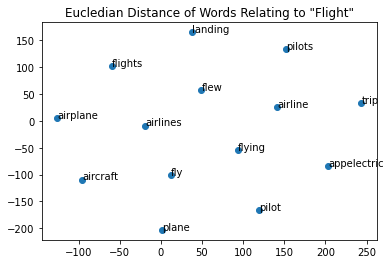

In [31]:
## t-distributed stochastic neighbor embedding ##
tsne = TSNE(n_components=2, random_state=0)
vectorized = [embedded_index[word] for words in exam_flight]
Y = tsne.fit_transform(vectorized)

## Plotting the example ##
fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o')
ax.set_title('Eucledian Distance of Words Relating to "Flight"')
for i, word in enumerate(exam_flight):
     plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))

### Model Building

In [32]:
########### Model Building #############

def model_data(mat, input_length):
    model = Sequential()
    model.add(Embedding(max_vocab_size, 300, input_length= input_length, weights=[mat],trainable=False))
    model.add(Conv1D(filters=32, kernel_size=8, activation='selu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='selu'))
    model.add(Dense(8, activation='sigmoid'))
    print(model.summary())
    return model

In [33]:
## Fitting the model on train data ##
model=model_data(embedded_mat, input_length)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train,y_train, epochs=5, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           189600    
                                                                 
 conv1d (Conv1D)             (None, 18, 32)            76832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 10)                2890      
                                                                 
 dense_1 (Dense)             (None, 8)                 88        
                                                        

In [34]:
## Results on Validation Set ##
model.evaluate(X_val,y_val)

31/31 [==============================] - 1s 14ms/step - loss: 0.1015 - accuracy: 0.9721


[0.10151144862174988, 0.9720786213874817]

### Evaluation Results

In [35]:
## Results on Test Data ##
def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

## Accuracy for Test Data 
predictions = model.predict(test_input)
print('Accuracy Score (Test Data):', acc(test_labels, predictions))

25/25 [==============================] - 3s 6ms/step
Accuracy Score (Test Data): 0.99125


In [37]:
# Saving model file
model.save(r'C:\Users\dell\Documents\Final_Project_Demo\model.h5')
print('Saved Successfully!')

Saved Successfully!


In [59]:
### Example ###

In [60]:
te_data=['What is my airfare for the flight to chicago?']
test_data_tokens = token(train_text).texts_to_sequences(te_data)
test_input = pad_sequences(test_data_tokens,25)
y_pred= model.predict(test_input)

1/1 [==============================] - 0s 37ms/step


In [61]:
y_hat = label_transformer.inverse_transform(np.argmax(y_pred,axis = 1)) 
y_hat

array(['atis_airfare'], dtype=object)

In [ ]:
#############################################################################################################################################